<img src='./figures/CEA_logo_nouveau.svg' style='position:absolute; top:0; right:0;' width='100px' height='' alt='' />

<center>Multi-fidelity Gaussian process regression </center>
<center><i>Practical Session</i> part II </center>

# Multi-Fidelity with DeepGP



In [1]:
#import
import GPy
import numpy as np
from matplotlib import pyplot as plt

### The data

#### A linear function to validate the model
The forester function

In [11]:
def high(x):
    return (5.5*x-2.5)**2*np.sin(12*x-4)

def low(x):
    return (6*x-2)**2*np.sin(12*x-4)

#### A non-linear function to test possibility
Sinus function

In [25]:
def high(x):
    return (x-np.sqrt(2))*low(x)**2

def low(x):
    return np.sin(8.0*np.pi*x)

#### Data for R

In [26]:
#import pandas as pd

#df = pd.read_csv (r'LowFiData.csv')
#X1 = np.asarray(df['XL'])[:,None]
#Y1 = np.asarray(df['ZL'])[:,None]
#df = pd.read_csv (r'HighFiData.csv')
#X2 = np.asarray(df['XH'])[:,None]
#Y2 = np.asarray(df['ZH'])[:,None]
#df = pd.read_csv (r'TestData.csv')
#Xtest = np.asarray(df['xD'])[:,None]
#Exact = np.asarray(df['testdata'])[:,None]
#PredR = np.asarray(df['pred'])[:,None]
#SigR = np.asarray(df['sig'])[:,None]

Definition of the variables

In [27]:
#dim=1
#Nts = Xtest.shape[0]
#N1 = X1.shape[0]
#N2 = X2.shape[0]

Definition du set de training

In [33]:
''' Define training and test points '''
dim = 1
s = 2
plot = 1
N1 = 15
N2 = 10
ensemble = 1

X1 = np.linspace(0,1, N1)[:,None]
perm = np.random.permutation(N1)
X2 = X1[perm[0:N2]]

Y1 = low(X1)
Y2 = high(X2)

## Test set
Nts = 400
Xtest = np.linspace(0,1, Nts)[:,None]
Exact= high(Xtest)
Low = low(Xtest)

## The regression

In [34]:
dim =1
active_dimensions = np.arange(0,dim)

''' Train level 1 '''
k1 = GPy.kern.RBF(dim, ARD = True)
m1 = GPy.models.GPRegression(X=X1, Y=Y1, kernel=k1)

m1[".*Gaussian_noise"] = m1.Y.var()*0.0
m1[".*Gaussian_noise"].fix()

m1.optimize(max_iters = 500)

m1[".*Gaussian_noise"].unfix()
m1[".*Gaussian_noise"].constrain_positive()

m1.optimize_restarts(30, optimizer = "bfgs",  max_iters = 1000)

mu1, v1 = m1.predict(X2)

''' Train level 2 '''
XX = np.hstack((X2, mu1))

k2 = GPy.kern.RBF(dim, active_dims = dim)*GPy.kern.RBF(dim, active_dims = [0]) \
             + GPy.kern.RBF(dim, active_dims = active_dimensions)

m2 = GPy.models.GPRegression(X=XX, Y=Y2, kernel=k2)

m2[".*Gaussian_noise"] = m2.Y.var()*0.0
m2[".*Gaussian_noise"].fix()

m2.optimize(max_iters = 500)

m2[".*Gaussian_noise"].unfix()
m2[".*Gaussian_noise"].constrain_positive()

m2.optimize_restarts(30, optimizer = "bfgs",  max_iters = 1000)

 /home/kerleguerb/Environements/.venv/lib/python3.9/site-packages/paramz/transformations.py:111: RuntimeWarning:divide by zero encountered in log
reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 1/30, f = 15.568027672816209
Optimization restart 2/30, f = 15.568027624700484
Optimization restart 3/30, f = 15.568028788911072
Optimization restart 4/30, f = 15.568028370547854
Optimization restart 5/30, f = 15.568032126645766
Optimization restart 6/30, f = 15.568027761635104
Optimization restart 7/30, f = 15.56802816773505
Optimization restart 8/30, f = 15.568027625532613
Optimization restart 9/30, f = 15.5680286295344
Optimization restart 10/30, f = 15.568031946989732
Optimization restart 11/30, f = 15.568030578233888
Optimization restart 12/30, f = 15.568034694525775
Optimization restart 13/30, f = 15.56803347191816
Optimization restart 14/30, f = 15.568035480187804
Optimization restart 15/30, f = 15.56803117810798
Optimization restart 16/30, f = 15.568027622223692
Optimization restart 17/30, f = 15.568028844893135
Optimization restart 18/30, f = 15.568030072919793
Optimization restart 19/30, f = 15.56802923282114
Optimization restart 20/30, f = 15.56803156116

reconstraining parameters GP_regression.Gaussian_noise.variance


Optimization restart 30/30, f = 15.568035707586565
Optimization restart 1/30, f = 0.16182071575637735
Optimization restart 2/30, f = 7.0012293686398035
Optimization restart 3/30, f = 7.001228759264773
Optimization restart 4/30, f = 7.001229536585462
Optimization restart 5/30, f = 7.001228782150024
Optimization restart 6/30, f = 7.0012303106520735
Optimization restart 7/30, f = 7.0012287625385135
Optimization restart 8/30, f = 7.001234349051125
Optimization restart 9/30, f = 7.001228792816375
Optimization restart 10/30, f = 7.001229244555251
Optimization restart 11/30, f = 7.001228762268915
Optimization restart 12/30, f = 7.0012294069665435
Optimization restart 13/30, f = 7.001228782609368
Optimization restart 14/30, f = 7.0012288514875305
Optimization restart 15/30, f = 7.001228937979881
Optimization restart 16/30, f = 7.001228850108651
Optimization restart 17/30, f = 7.001228766310031
Optimization restart 18/30, f = 7.001228847478615
Optimization restart 19/30, f = 7.001230861858353
O

### The sampling of the posterior

In [35]:
NS1 = 100
NS2 = 30

# sample f_1 at xtest
mu1, C1 = m1.predict(Xtest, full_cov=True)
Z = np.random.multivariate_normal(mu1.flatten(),C1,NS1)

f2Samples = np.zeros((NS1*NS2,Nts))
for i in range(0,NS1):
    f2Samples[i*NS2:(i+1)*NS2,:] = m2.posterior_samples_f(np.hstack((Xtest, Z[i,:][:,None])), full_cov=True, size=NS2)[:,0,:].T

plot

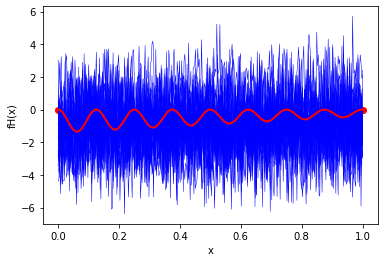

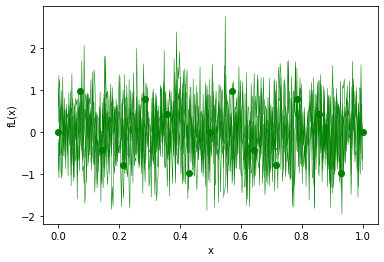

In [36]:
fig, ax = plt.subplots()
plt.plot(X2, Y2,'ro')
for i in range(20):
    plt.plot( Xtest, f2Samples[(i*NS2)%(NS2*NS1)+1,:], 'b',  linewidth = 0.5)

plt.plot(Xtest, Exact, 'r', linewidth=2)
plt.xlabel("x")
plt.ylabel("fH(x)")
plt.show()

fig, ax = plt.subplots()
plt.plot(X1, Y1,'go')
for i in range(5):
    plt.plot( Xtest, Z[i,:][:,None], 'green',  linewidth = 0.5)

plt.xlabel("x")
plt.ylabel("fL(x)")
plt.show()

**Question 1** -Change the variance in order to recreate the AR(1) model

**Question 2** - Change the variance in order to presente a misture between AR(1) and DeepGP

**Question 3** - Plot the posterior distribution in a specific point 

**Question 4**- Create uncertainty intervalls

**Question 5**- Use the Perdikaris solution and explain

In [30]:
''' Predict at test points '''
# sample f_1 at xtest
nsamples = 1000
mu1, C1 = m1.predict(Xtest, full_cov=True)
Z = np.random.multivariate_normal(mu1.flatten(),C1,nsamples)

# push samples through f_2
tmp_m = np.zeros((nsamples,Nts))
tmp_v = np.zeros((nsamples,Nts))
for i in range(0,nsamples):
    mu, v = m2.predict(np.hstack((Xtest, Z[i,:][:,None])))
    tmp_m[i,:] = mu.flatten()
    tmp_v[i,:] = v.flatten()

# get posterior mean and variance
mean = np.mean(tmp_m, axis = 0)[:,None]
var = np.mean(tmp_v, axis = 0)[:,None]+ np.var(tmp_m, axis = 0)[:,None]
var = np.abs(var)

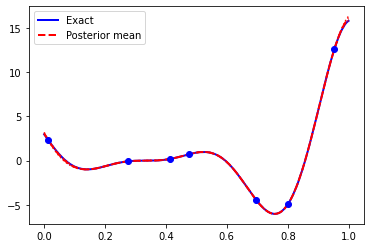

In [32]:
f = plt.figure()
plt.plot(Xtest, Exact, 'b', label='Exact', linewidth = 2)
plt.plot(Xtest, mean, 'r--', label = 'Posterior mean', linewidth = 2)
plt.plot(Xtest, mean + 2.0*np.sqrt(var), 'r:')
plt.plot(Xtest, mean - 2.0*np.sqrt(var), 'r:')
    
#    plt.plot(Xtest, PredR, 'g--', label = 'Posterior mean AR(1)', linewidth = 2)
#    plt.plot(Xtest, PredR + 2.0*SigR, 'g:')
#    plt.plot(Xtest, PredR - 2.0*SigR, 'g:')
    # plt.plot(X1, Y1,'g.')
plt.plot(X2, Y2,'bo')
plt.legend()
plt.show()

#plt.figure()
#plt.plot(Low, Exact, label = "Exact")
#plt.plot(mu1, mean, label = "Predicted ")
#plt.legend()
#
#plt.show()

## Multi-Fidelity neural network

In [19]:
import torch
import math

Definition the function with torch

In [1]:
#def fL(x):
#    return( 0.5 * (6*x -2)**2*torch.sin(12*x-4)+ 10 * (x-0.5) -5)
#
#def fH(x):
#    return( (6*x -2)**2*torch.sin(12*x-4))

Conversion to torch

In [20]:
#NL , NH = 11 , 4
xL = torch.from_numpy( X1).float() ## torch.reshape( torch.linspace( 0, 1, NL), (NL,1))
xH = torch.from_numpy( X2).float() ## torch.reshape( torch.linspace( 0, 1, NH), (NH,1))
yL = torch.from_numpy( Y1).float() ## fL(xL)
yH = torch.from_numpy( Y2).float() ## fH(xH)

In [21]:
class DNN(torch.nn.Module):
    def __init__(self, D_in, H, D, D_out):
        super(DNN, self).__init__()
        self.inputlayer = torch.nn.Linear( D_in, H)
        self.middle = torch.nn.Linear( H, H)
        self.lasthiddenlayer = torch.nn.Linear( H, D)
        self.outputlayer = torch.nn.Linear( D, D_out)

    def forward(self, x):
        y_pred = self.outputlayer(self.PHI(x))
        return y_pred

    def PHI(self, x):
        h_relu = self.inputlayer(x).tanh()
        for i in range(2):
            h_relu = self.middle(h_relu).tanh()
        phi = self.lasthiddenlayer(h_relu)
        return(phi)

Definition of the model

In [34]:
# Construct our model by instantiating the class defined above
modelLF = DNN(1, 20, 20, 1) # for low fidelity
modelHFNL = DNN(2, 20, 20, 1)

Definition of the loss function

In [35]:
loss_fn = torch.nn.MSELoss(reduction='sum')

Learning rate

In [40]:
lr =1e-5
optimizerLF = torch.optim.SGD(modelLF.parameters(), lr=lr)
optimizerHF = torch.optim.SGD(modelHFNL.parameters(), lr=lr)

In [41]:
for t in range(100000):
    # Forward pass: compute predicted y by passing x to the model.
    y_predLF = modelLF(xL)

    # Compute and print loss.
    loss = loss_fn(y_predLF, yL)
    if math.isnan(loss):
        print(t)
        break
    if t % 1000 == 0:
        print(t, loss.item())

    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable
    # weights of the model). This is because by default, gradients are
    # accumulated in buffers( i.e, not overwritten) whenever .backward()
    # is called. Checkout docs of torch.autograd.backward for more details.
    optimizerLF.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizerLF.step()

0 8.926034927368164
1000 8.111006736755371
2000 7.433140277862549
3000 6.874655246734619
4000 6.41646146774292
5000 6.038882255554199
6000 5.72270393371582
7000 5.4503631591796875
8000 5.206999778747559
9000 4.981124401092529
10000 4.764952659606934
11000 4.55413293838501
12000 4.346728324890137
13000 4.141889572143555
14000 3.9388439655303955
15000 3.73716402053833
16000 3.536550283432007
17000 3.337402820587158
18000 3.1406233310699463
19000 2.947594404220581
20000 2.7598958015441895
21000 2.5793826580047607
22000 2.4078025817871094
23000 2.246612548828125
24000 2.0969245433807373
25000 1.9594141244888306
26000 1.8342928886413574
27000 1.7213191986083984
28000 1.6199465990066528
29000 1.5293200016021729
30000 1.4484678506851196
31000 1.376294493675232
32000 1.3117146492004395
33000 1.253716230392456
34000 1.2013527154922485
35000 1.1537892818450928
36000 1.1102936267852783
37000 1.070259690284729
38000 1.0332014560699463
39000 0.9987150430679321
40000 0.966467022895813
41000 0.936182

In [42]:
#High fidelity learning
for t in range(20000):
    # Forward pass: compute predicted y by passing x to the model.
    y_predHF = modelHFNL(torch.cat([xH,modelLF(xH)], 1))

    # Compute and print loss.
    loss = loss_fn(y_predHF, yH)
    if t % 1000 == 0:
        print(t, loss.item())

    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable
    # weights of the model). This is because by default, gradients are
    # accumulated in buffers( i.e, not overwritten) whenever .backward()
    # is called. Checkout docs of torch.autograd.backward for more details.
    optimizerHF.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizerHF.step()

0 201.23377990722656
1000 195.237548828125
2000 177.2162628173828
3000 111.65757751464844
4000 40.91151428222656
5000 7.777008533477783
6000 3.1498568058013916
7000 1.3281506299972534
8000 0.5654130578041077
9000 0.26311784982681274
10000 0.1409362256526947
11000 0.0889897495508194
12000 0.06572221219539642
13000 0.054824963212013245
14000 0.04951055720448494
15000 0.04679714888334274
16000 0.045319389551877975
17000 0.044439200311899185
18000 0.043849118053913116
19000 0.04340352863073349


A more complex problem with parallel network for the high fidelity

In [22]:
class DNNHF(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super(DNNHF, self).__init__()
        self.inputlayer = torch.nn.Linear( D_in, H)
        self.middle = torch.nn.Linear( H, H)
        self.outputlayer = torch.nn.Linear( H, D_out)

    def forward(self, x):
        y_pred = self.outputlayer(self.PHI(x)) + self.outputlayer(self.PHIL(x))
        return y_pred
    
    def PHIL(self, x):
        phi = self.inputlayer(x)
        for i in range(2):
            phi = self.middle(phi)
        return(phi)

    def PHI(self, x):
        phi = self.inputlayer(x).tanh()
        for i in range(2):
            phi = self.middle(phi).tanh()
        return(phi)

Definition of the model

In [51]:
modelLF2 = DNN(1, 20, 20, 1) # for low fidelity
modelHF = DNNHF(2, 20, 1) # for high fidelity

In [52]:
lr =0.0001
optimizerLF = torch.optim.SGD(modelLF2.parameters(), lr=lr)

In [53]:
for t in range(100000):
    # Forward pass: compute predicted y by passing x to the model.
    y_predLF = modelLF2(xL)

    # Compute and print loss.
    loss = loss_fn(y_predLF, yL)
    if math.isnan(loss):
        print(t)
        break
    if t % 10000 == 0:
        print(t, loss.item())

    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable
    # weights of the model). This is because by default, gradients are
    # accumulated in buffers( i.e, not overwritten) whenever .backward()
    # is called. Checkout docs of torch.autograd.backward for more details.
    optimizerLF.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizerLF.step()

0 490.6528015136719
10000 0.43830710649490356
20000 0.3938136398792267
30000 0.3458513021469116
40000 0.29129892587661743
50000 0.21129193902015686
60000 0.0836380273103714
70000 0.020429108291864395
80000 0.013085715472698212
90000 0.010466012172400951


In [54]:
lr = 0.0001
optimizerHF = torch.optim.SGD(modelHF.parameters(), lr=lr)

In [55]:
for t in range(20000):
    # Forward pass: compute predicted y by passing x to the model.
    y_predHF = modelHF(torch.cat([xH,modelLF2(xH)], 1))

    # Compute and print loss.
    loss = loss_fn(y_predHF, yH)
    if t % 1000 == 0:
        print(t, loss.item())

    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable
    # weights of the model). This is because by default, gradients are
    # accumulated in buffers( i.e, not overwritten) whenever .backward()
    # is called. Checkout docs of torch.autograd.backward for more details.
    optimizerHF.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizerHF.step()

0 205.71627807617188
1000 2.585496425628662
2000 3.9566760063171387
3000 0.6840872764587402
4000 0.15516096353530884
5000 0.04280712455511093
6000 0.022196760401129723
7000 0.019964255392551422
8000 0.019247716292738914
9000 0.01865360699594021
10000 0.018123731017112732
11000 0.017637038603425026
12000 0.017180299386382103
13000 0.016745373606681824
14000 0.016325443983078003
15000 0.01591716893017292
16000 0.01551888883113861
17000 0.01512901484966278
18000 0.014746800065040588
19000 0.01437182817608118


The result of the model

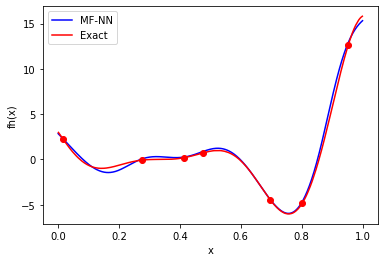

In [57]:
Ntest = 1000
xx = torch.reshape( torch.linspace( 0, 1, Ntest), (Ntest,1))
plt.plot(xx,modelHF(torch.cat([xx,modelLF2(xx)], 1)).detach().numpy(),'b', label = "MF-NN")
plt.plot(Xtest, Exact,'r', label = "Exact")
plt.plot(xH, yH, 'or')
#plt.plot(xL, yL, 'o')
plt.xlabel('x')
plt.ylabel('fh(x)')
plt.legend()
plt.show()